# Capstone Project - The Battle of the Neighborhoods (Week 1)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The current project has as objective to discover the best possible location in Santiago de Chile for **starting a new bar entrepreneurship focused on selling premium craft beers to customers.**

Santiago de Chile has around 7MM people living in an area of 15.400 km2 partitioned in 52 different boroughs. **These boroughs have a population, number of houses, area and a large array of different amenities given.**

Our mission is to **leverage different data science tools that helps to determine which boroughs are the most promising and venues inside these ones to locate the stakeholders’ bar.**

The criteria used for the analysis are:

* **Boroughs with high density of people** would be prefer in order to assure a flow of customers into the bar.
* **Boroughs with low number of people per house** will be prefer due to singles and young couples used to visit more bars than families with kids.
* We will prefer **locations with many restaurants, cinemas, theaters, discos and bars** in order to gain exposure for the targeted customers but **avoiding proximity to bars delivering our same services.**


## Data <a name="data"></a>

In [4]:
#!pip install lxml

import pandas as pd
import numpy as np
import lxml
import re
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


For this project we will use 3 main streams of data


In order to solve our problem of best location discovery with need data about the boroughs, specially that one pointing their location, secondly demographics about each borough that allow us to discriminate the boroughs with more potential and thirdly, hot places with complementary and suitable amenities to locate the beer bar that allow us to assurance its future growth and healthy revenues.

### 1.	Data about the boroughs and their location
The data came from a link in Wikipedia that has all the cities and boroughs in Chile and their corresponding latitude and longitude.





In [5]:
url='https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile'
df=pd.read_html(url, header=0)[0]

We must filter for the boroughs in Santiago, convert the format for the coordinates and drop those columns that are useless for our propose. It is important to notice that each borough has a unique identifier call “CUT” which is useful to cross data later.

In [6]:
def dms2dd(s):
    deg, minutes, seconds, direction =  re.split('[°\'"]', s)
    dd = (float(deg) - float(minutes)/60-float(seconds)/(60*60))
    return dd

In [7]:
df=df[df['Provincia']=='Santiago']
df.drop(['Provincia','Unnamed: 2','Región','IDH 2005','IDH 2005.1', 'Superficie(km2)',"Población2017",'Densidad(hab./km2)' ], axis=1, inplace=True)
df['Latitud']=df['Latitud'].str.replace(",",".")
df['Longitud']=df['Longitud'].str.replace(",",".")
df['Latitude'] = df['Latitud'].apply(dms2dd)
df['Longitude'] = df['Longitud'].apply(dms2dd)
df.drop(['Latitud','Longitud'], axis=1, inplace=True)
df.rename(columns={"CUT (Código Único Territorial)": "CUT", "Nombre": "Borough"}, inplace=True)
df.head()

,CUT,Borough,Latitude,Longitude
294,13101,Santiago,-33.437222,-70.657222
295,13102,Cerrillos,-33.500000,-70.716667
296,13103,Cerro Navia,-33.422000,-70.735000
297,13104,Conchalí,-33.380000,-70.675000
298,13105,El Bosque,-33.567000,-70.675000


Here we can use folium to map all boroughs. We can notice that points are distributed in a circular area

In [10]:
address = 'Santiago, RM'
geolocator = Nominatim(user_agent="cl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_santiago= folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_santiago)  
    
map_santiago

### 2.	Data about population, number of houses and area of boroughs
In this case the data was extracted from a csv file posted by “Instituto Nacional de Estadisticas” (public institution focused on creating indices and data in Chile).




In [17]:
url= 'https://opendata.arcgis.com/datasets/1c64fcb18f5a41e088b25ef9f42b58d7_0.csv?outSR=%7B%22wkid%22%3A102100%2C%22latestWkid%22%3A3857%7D'
df_population=pd.read_csv(url)

Again, we filter the columns that were useful and the rows with information about the boroughs in Santiago



In [18]:
df_population=df_population[df_population['NOM_PROVIN']=='SANTIAGO']
df_pop=df_population.filter(['COMUNA','T_POB','T_VIV','SUPERFICIE__KM2_','Densidad_'], axis=1)
df_pop.rename(columns={'COMUNA':'CUT',"T_POB": "Population", "T_VIV": "Houses", "SUPERFICIE__KM2_":"Area (km2)",'Densidad_':'Density'}, inplace=True)
df_pop.head()

,CUT,Population,Houses,Area (km2),Density
274,13102,80832,24547,16.779650,4817.263672
275,13131,82900,23855,6.277112,13206.710938
276,13132,85384,31777,28.417034,3004.676758
278,13109,90119,31480,9.979139,9030.739258
283,13113,92787,29801,23.438091,3958.812012


Here we can cross this dataframe with the previous one thanks to the ‘CUT’ code, generating a unique table with information of 32 boroughs

In [19]:
df=df.merge(df_pop, left_on='CUT', right_on='CUT')

In [23]:
df['People/House']=df['Population']/df['Houses']
print(df.shape)
df.head()

(32, 9)


,CUT,Borough,Latitude,Longitude,Population,Houses,Area (km2),Density,People/House
0,13101,Santiago,-33.437222,-70.657222,404495,193628,23.135237,17483.935547,2.089032
1,13102,Cerrillos,-33.500000,-70.716667,80832,24547,16.779650,4817.263672,3.292948
2,13103,Cerro Navia,-33.422000,-70.735000,132622,38020,11.097359,11950.771484,3.488217
3,13104,Conchalí,-33.380000,-70.675000,126955,37759,11.109763,11427.335938,3.362245
4,13105,El Bosque,-33.567000,-70.675000,162505,47941,14.324402,11344.626953,3.389687


#### We are able to extract 3 insights

Around half of the boroughs (15) have low density of people (<8.8k people/km2) and the other half high density (>8.8k people/km2). We must focus on this half.

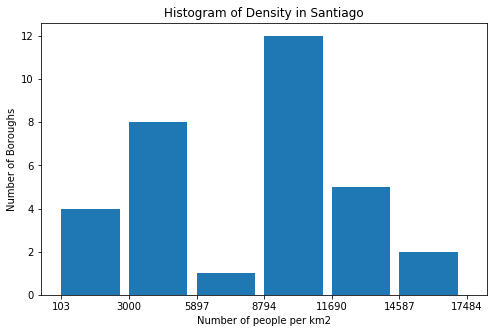

In [26]:
count, bin_edges = np.histogram(df['Density'], 6)

df['Density'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, bins=6, width=2500)

plt.title('Histogram of Density in Santiago')
plt.ylabel('Number of Boroughs') 
plt.xlabel('Number of people per km2') 
plt.show()

Around one third of the boroughs (10) have a low number of people per houses (<2.85 people/house). We must focus on this third.

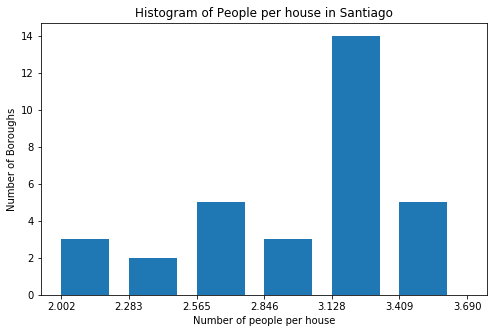

In [28]:
count, bin_edges = np.histogram(df['People/House'], 6)

df['People/House'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, bins=6, width=.2)

plt.title('Histogram of People per house in Santiago')
plt.ylabel('Number of Boroughs')
plt.xlabel('Number of people per house') 
plt.show()

Finally, with the 2 previous pieces of information we have a quadrant of interest to put focus on

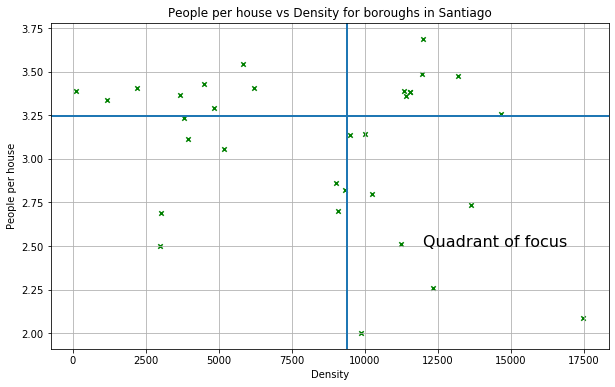

In [30]:
df.plot(kind='scatter', x='Density', y='People/House', figsize=(10, 6),  color='green', marker='x')

plt.title('People per house vs Density for boroughs in Santiago')
plt.xlabel('Density')
plt.ylabel('People per house')
plt.annotate('Quadrant of focus', xy=(12000, 2.5), size=16)
plt.grid(True)
plt.axhline(y=df['People/House'].median(), linewidth=2)
plt.axvline(x=df['Density'].median(), linewidth=2)
plt.show()

### 3.	Data about the venues and their location for each borough
Thanks to the Foursquare API we can extract the location and category for every Venue located in each borough of Santiago.
To extract the info, we use the proper credentials and a range of 2 kilometers around each borough and a limit of 100 venues per borough.

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                      'Borough Latitude', 
                      'Borough Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']

    return(nearby_venues)

In [33]:
santiago_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

santiago_venues

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santiago,-33.437222,-70.657222,Plaza de Bolsillo - Santiago Centro,-33.436778,-70.655481,Plaza
1,Santiago,-33.437222,-70.657222,Starbucks,-33.437938,-70.657007,Coffee Shop
2,Santiago,-33.437222,-70.657222,Amanda's,-33.439206,-70.658247,Arepa Restaurant
3,Santiago,-33.437222,-70.657222,Museo Chileno de Arte Precolombino,-33.438776,-70.652363,Museum
4,Santiago,-33.437222,-70.657222,GYROS BISTRÓ,-33.439793,-70.655792,Sandwich Place
...,...,...,...,...,...,...,...
1883,Vitacura,-33.400000,-70.600000,Eric Kayser,-33.416495,-70.597481,Deli / Bodega
1884,Vitacura,-33.400000,-70.600000,Check INN,-33.388067,-70.615203,Restaurant
1885,Vitacura,-33.400000,-70.600000,Brooks Night,-33.389916,-70.615861,Athletics & Sports
1886,Vitacura,-33.400000,-70.600000,Ultra Music Festival - Chile 2015,-33.391467,-70.617569,Concert Hall


 Due to the big range we must look for possible duplicates in the dataframe

In [34]:
santiago_venues.drop_duplicates(subset =['Venue','Venue Latitude', 'Venue Longitude'], inplace=True)
print(santiago_venues.shape)

(1630, 7)


Finally, we can notice that there are a huge variance in the number of venues per borough

In [35]:
santiago_venues.groupby(['Borough']).count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Cerrillos,56,56,56,56,56,56
Cerro Navia,19,19,19,19,19,19
Conchalí,52,52,52,52,52,52
El Bosque,26,26,26,26,26,26
Estación Central,59,59,59,59,59,59
Huechuraba,24,24,24,24,24,24
Independencia,73,73,73,73,73,73
La Cisterna,74,74,74,74,74,74
La Florida,24,24,24,24,24,24


## Methodology <a name="methodology"></a>

## Analysis <a name="analysis"></a>

## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>

In [31]:
CLIENT_ID = 'LIBU3ZBXSVMVDGM0CPL1BKG2OLRFYZ1HAR3OWDU5RIN4VB30' # your Foursquare ID
CLIENT_SECRET = 'WVMMAU40EHWIECRKOAHZHWH350XL52GHJC2Q2F02DAVO5FO0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version